[info] 开始...


100%|██████████| 25/25 [00:01<00:00, 15.07it/s]


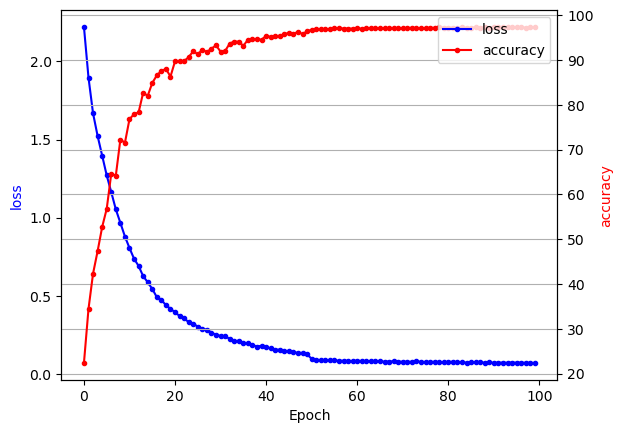

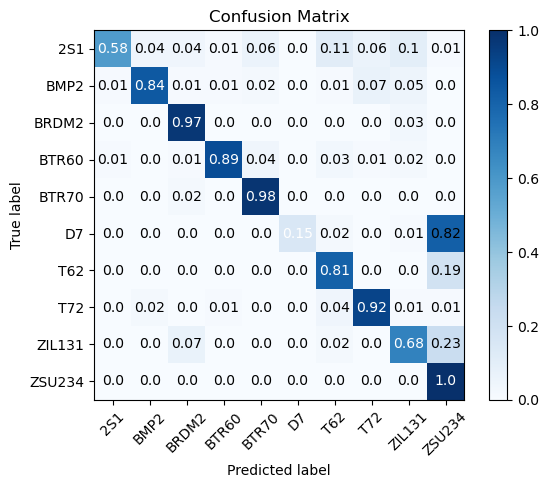

In [2]:
import os
import sys

import numpy as np
import torch
from tqdm import tqdm

# 如果在jupyter中运行，则打开注释，因为运行本文件之前不会运行__init__.py
current_directory = os.getcwd()
SRC = os.path.abspath(os.path.join(current_directory, '..'))  # 假设 src 目录在当前目录的上一级
if SRC not in sys.path:
    sys.path.append(SRC)

from src.datasets.processed_data import data_loader
from src.utils.general import ROOT, set_random_seed, plot_confusion_matrix, plot_loss_accuracy
from src import model

@torch.no_grad()
def get_labels(model_temp, data_set):
    """
    测试当前模型效果，并获取分类准确率
    """
    _pred_label_list = []
    _true_label_list = []

    model_temp.net.eval()   # 设置模型为评估模式

    _softmax = torch.nn.Softmax(dim=1)

    for i, data in enumerate(tqdm(data_set)):
        images, labels, _ = data

        predictions = model_temp.inference(images.float())  # 模型推理
        predictions = _softmax(predictions)                 # 使用Softmax函数获取概率分布
        # 获取索引，即预测的类别
        _, predictions = torch.max(predictions.detach(), 1)

        labels = labels.type(torch.LongTensor)

        # 将预测标签和真实标签添加到列表中
        _pred_label_list.append(predictions.cpu().numpy())
        _true_label_list.append(labels.cpu().numpy())

    return _pred_label_list, _true_label_list


def run(data_path, dataset_name, batch_size, patch_size,
        classes, channels, lr, checkpoint_path):
    # 模型的保存路径（记得注释掉！！！！！！！！！！！！！！！！！！）
    # checkpoint_path = r"E:\code\objectDetection\AConvNet\outputs\checkpoints\soc\epoch-99\model-soc-99.pth"

    # 加载保存的模型
    AConvNet = model.AConvNetModel(
        classes=classes, channels=channels, lr=lr, dropout_rate=0.5
    )

    checkpoint = torch.load(checkpoint_path)
    AConvNet.net.load_state_dict(checkpoint['model_state_dict'])

    # 将模型设置为评估模式
    AConvNet.net.eval()

    # 加载测试数据集
    data_set = data_loader.load_dataset(data_path=data_path, is_train=False, dataset_name=dataset_name,
                                        patch_size=patch_size, batch_size=batch_size)

    # 在测试集上执行推理
    pred_label_list, true_label_list = get_labels(AConvNet, data_set)
    all_pred_labels = np.concatenate(pred_label_list)
    all_true_labels = np.concatenate(true_label_list)
    labels_name = sorted(['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU234'])

    plot_loss_accuracy(
        data_set_result_path=r"E:\code\objectDetection\AConvNet\outputs\checkpoints\soc",
        img_save_path=r'E:\code\objectDetection\AConvNet\outputs\images'
    )

    plot_confusion_matrix(all_true_labels, all_pred_labels, labels_name, title="Confusion Matrix", is_norm=True, img_save_path=r'E:\code\objectDetection\AConvNet\outputs\images')



print("[info] 开始...")


# 设置随机数种子
set_random_seed(666)

run(data_path=rf'{ROOT}/data',
    dataset_name='soc',
    patch_size=88,
    batch_size=100,
    classes=10,
    channels=1,
    lr=0.001,
    checkpoint_path=rf'{ROOT}/outputs/checkpoints/soc/epoch-96/model-soc-96.pth'
    )

